# Project 1: Replication of Loughran and MacDonald Analysis

### Natural Language Processing

Team: Shizi Liu, Yao Zheng, Zhuqing Yang

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sec_edgar_downloader import Downloader
from nltk.stem import WordNetLemmatizer
import matplotlib.ticker as mtick
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from itertools import islice
import pysentiment2 as ps
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import unicodedata
import requests
import warnings
import pickle
import pprint
import wrds
import nltk
import re
import os

warnings.filterwarnings("ignore")
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/daphneyang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 1: Get Data and map CIK

The goal of this step is to map companies’ permno code with CIK code, to be ready for downloading corresponding 10-Q and 10-K files on EDGAR.

In [ ]:
# Load the sp500 permno file and only keep the information that will be used later
sp500_permno = pd.read_csv("sp500_w_addl_id.csv", sep=",")
sp500_permno = sp500_permno[["permno", "date"]]

In [ ]:
# Load the sp500 permno to cik file
cik_map = pd.read_csv("PERMNO_to_cik.csv", sep=",")
cik_map = cik_map[["LPERMNO","datadate","cik"]]

In [ ]:
# Map the cik to permno for each company in the sp500, drop all nan rows
sp500_merge = sp500_permno.merge(cik_map, left_on = ["permno", "date"], right_on = ["LPERMNO", "datadate"])
sp500 = sp500_merge[["date", "permno", "cik"]].dropna()
sp500['cik'] = sp500['cik'].apply(int)
sp500['cik'] = sp500['cik'].apply(str)

In [ ]:
# Change the cik column's format for more convenient usage in iteration later.
CIKs = list(sp500.cik.unique())
CIKs_list = list(map(str, CIKs))

In [ ]:
# Use for downloading daily close price with cik as keys from wrds compustats
with open("ciks_list.txt", 'w') as file:
        for row in CIKs_list:
            s = "".join(map(str, row))
            file.write(s+'\n')

# Step 2: Download and parse 10-K and 10-Q data 

This step includes two sub steps: (1) downloading and parsing data to remove redundant content from all files; (2) lemmatizing parsed files to make the further word counting steps more efficient. 

## Step 2.1: Downloading and parsing data

We spent much time thinking how to download and parse data in high efficiency. Initially we tried to download all the raw txt data with the official API, but too much disk space was occupied, and we believe this was certainly not an optimal way. We thought out of the box and tried parsing before downloading by making use of the unique URL for viewing each 10-Q and 10-K in html form.

We first temporally stored the data in a string by decomposing and requesting URL link of all 10-Qs and 10-Ks. Then we applied beautiful soup method to parse raw data, including removing tags, special characters, blank lines, etc. We also delete numbers and single characters in the step of calculating weights and more explanation will be made within following parsing function. 

In [ ]:
# The parsing scheme designed by our group
def MyParsing(raw):
    # Apply bs4 to remove html tags
    soup = BeautifulSoup(raw, 'lxml').get_text()
    # Encoding to remove special characters
    soup = str(soup.encode('ascii', errors = 'ignore'), 'utf-8')
    # Remove blank lines
    soup = os.linesep.join([s for s in soup.splitlines() if s])
    # Remove useless tags inside various brackets
    soup = re.sub("<.*?>", "", soup)
    soup = re.sub(r'\[[^)]*\]', "", soup)
    soup = re.sub(r' {[^}]*}', "", soup)
    # Remove mess code text after a fixed location (the start of financial report) in every file
    bad_ind = soup.find('Financial_Report.xlsx')
    soup = soup[:bad_ind]
    # Remove initial mess code
    index = soup.find('UNITED') 
    soup = soup[index:] 
    # Remove blank lines again after all these new changes
    soup = os.linesep.join([s for s in soup.splitlines() if s])
    return soup

After parsing, we built dictionaries for each CIK with their filing dates as dictionary keys and download them as pickle files, which enables faster processing speed and save more space on our computers. In total, we downloaded 712 dictionaries in pickle files.

In [ ]:
import pickle
from tqdm import tqdm

# Loop through each cik to download corresponding 10Ks and 10Qs, and parse
for i in tqdm(range(len(CIKs_list))):
    cik = CIKs_list[i]
    print(cik)
    cik_0 = cik.zfill(10)
    headers = {'User-Agent': 'fsdff@gmail.com'}
    # Access filing information from EDGAR
    r = requests.get('https://data.sec.gov/submissions/CIK' + cik_0 + '.json', headers = headers)
    raw_10k = r.json()

    info = raw_10k['filings']['recent']
    Form = np.array(info['form'])
    Acc_Num = np.array(info['accessionNumber'])

    # Store accession numbers for url composition, Q for 10-Q, K for 10-K
    AccQ = Acc_Num[Form == '10-Q']
    AccK = Acc_Num[Form == '10-K']
    accq = np.array([i.replace('-','') for i in AccQ])
    acck = np.array([i.replace('-','') for i in AccK])

    # Dictionary to store parsed documents
    one_company = {}
    for i in range(len(accq)):
        # Limit 10Q files needed from 2016~2021
        if (int(accq[i][10:12]) >= 16) and (int(accq[i][10:12]) <= 21):
            url = "https://www.sec.gov/Archives/edgar/data/" + cik + "/" + accq[i] + "/" + AccQ[i] + ".txt"

            headers = {'User-Agent': '123456748@gmail.com'}
            r = requests.get(url, headers = headers).text
            # Store the parsed documents with accession numbers as keys to the dictionary for each cik
            one_company[accq[i][-7:]] = MyParsing(r)

    # Same for all 10-K documents
    for i in range(len(acck)):
        if int(acck[i][10:12]) >= 16 and (int(acck[i][10:12]) <= 21):
            url = "https://www.sec.gov/Archives/edgar/data/" + cik + "/" + acck[i] + "/" + AccK[i] + ".txt"

            headers = {'User-Agent': '12345f6798@gmail.com'}
            r = requests.get(url, headers = headers).text
            one_company[acck[i][-7:]] = MyParsing(r)


    # save dictionary to pickle file to save storage
    with open(cik + '.pickle', 'wb') as file:
        pickle.dump(one_company, file)

Because 700+ files were difficult for one person's computer to parse, each of us in our group downloaded and parsed 200+ of them separately, below is the demonstration of part of pickle files saved by one of us:

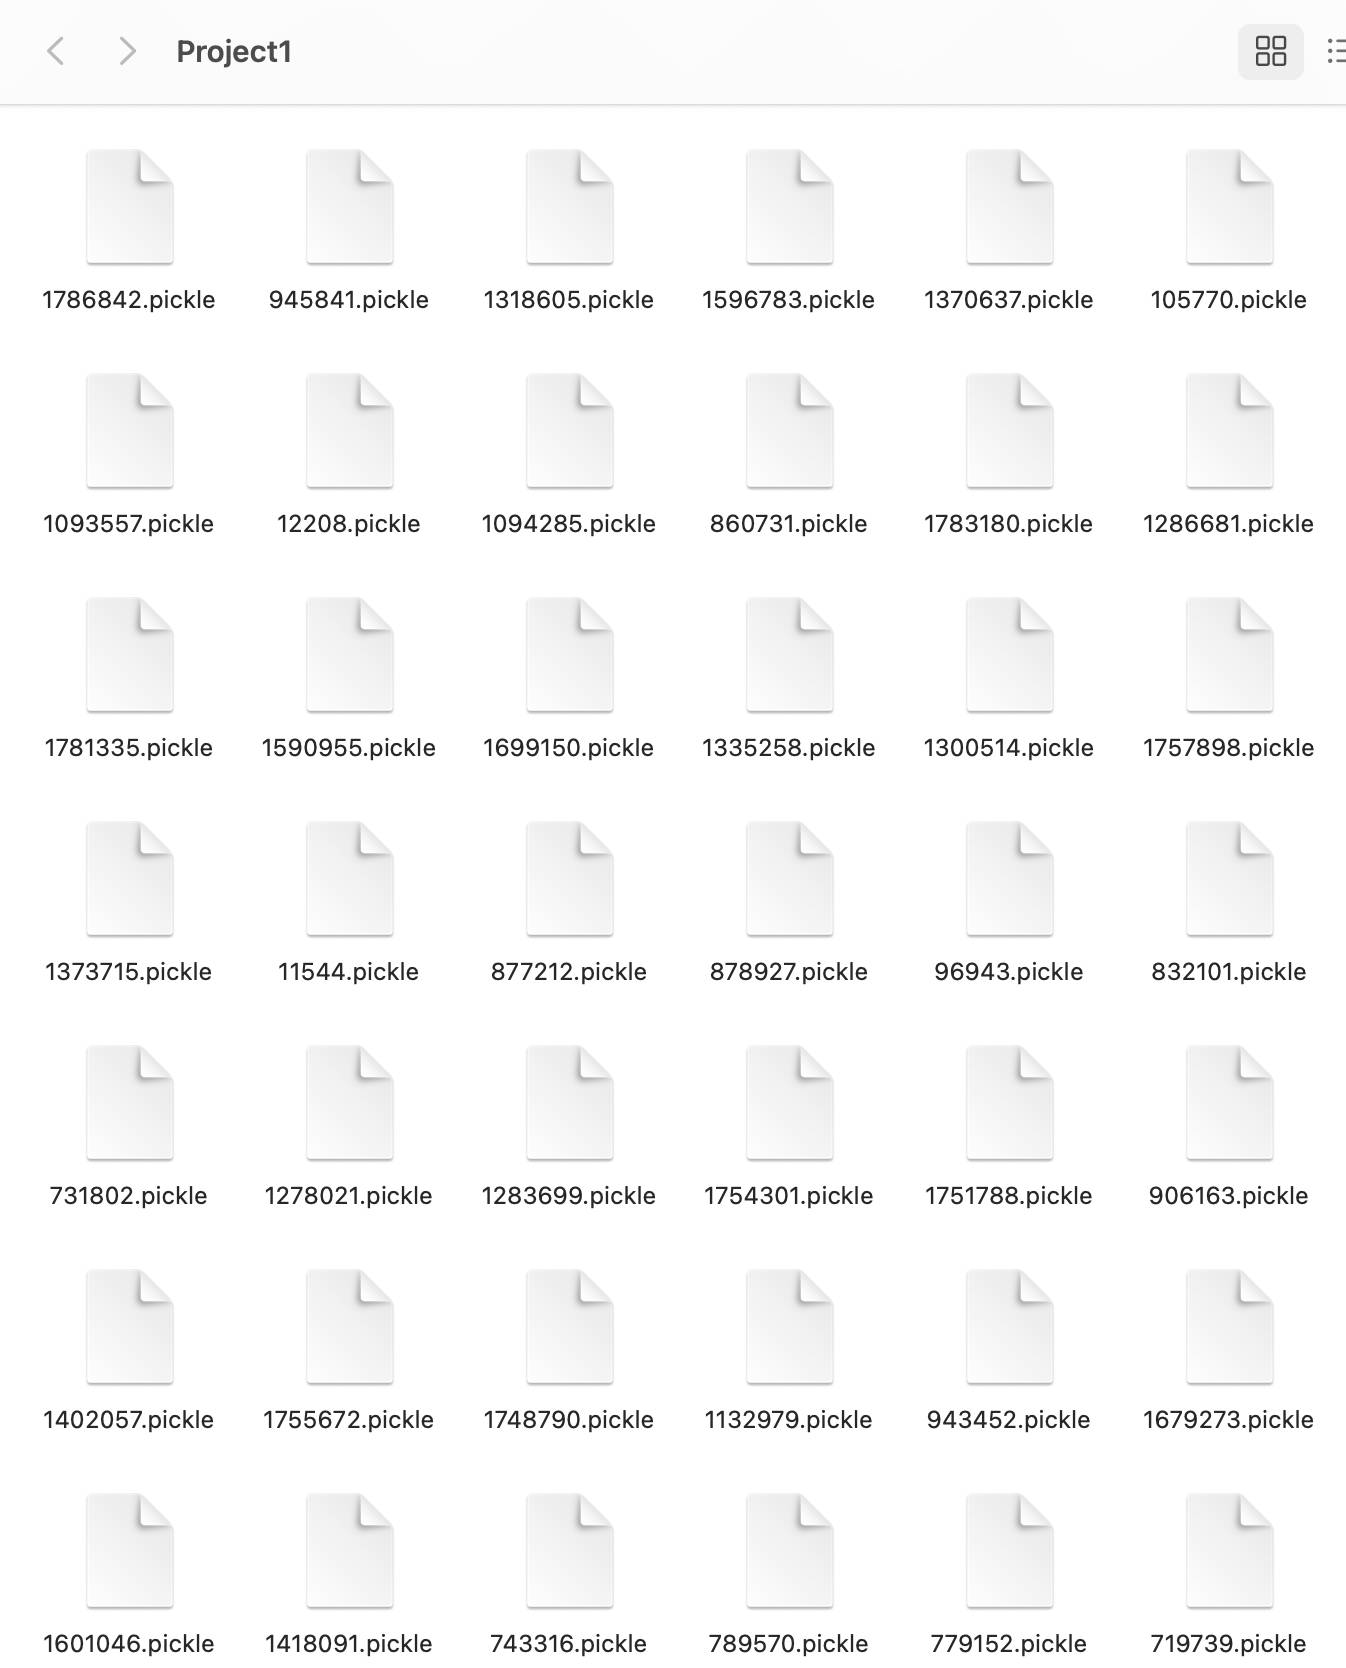

And a partial demonstration of a parsed cik document using our parsing function:

In [2]:
with open('945841' + '.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [10]:
b.keys()

dict_keys(['1000178', '1000141', '1000069', '0000210', '0000173', '0000102', '9000155', '9000116', '9000067', '8000114', '8000091', '8000057', '7000140', '7000116', '7000082', '6000285', '6000269', '6000233', '1000022', '0000041', '9000013', '8000020', '7000028', '6000190'])

In [15]:
b['1000178'][:2500]

'UNITED STATESSECURITIES AND EXCHANGE COMMISSIONWashington, D.C. 20549FORM 10-Q QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the quarterly period ended September 30, 2021 orTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934For the transition period from  to Commission File Number: 0-26640 POOL CORPORATION(Exact name of registrant as specified in its charter)Delaware36-3943363(State or other jurisdiction of(I.R.S. Employerincorporation or organization)Identification No.)109 Northpark Boulevard,Covington,Louisiana70433-5001(Address of principal executive offices)(Zip Code)(985) 892-5521 (Registrants telephone number, including area code)Securities registered pursuant to Section 12(b) of the Act:Title of each classTrading Symbol(s)Name of each exchange on which registeredCommon Stock, par value $0.001 per sharePOOLNasdaq Global Select MarketIndicate by check mark whether the registrant (1)has filed all rep

## Step 2.2: Lemmatizing data

We looped through every previously saved dictionary pickle file and used a cited function to lemmatize data. After that we stored them again in dictionary pickle files, set the filing date as keys. 

In [ ]:
# Lemmatize function cited from https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92
def lemmatize_words(words):
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    return lemmatized_words

word_pattern = re.compile('\w+')
# Loop through the cik list
for i in tqdm(range(len(CIKs_list))):
    
    cik = CIKs_list[i]
    print(cik)
    cik_0 = cik.zfill(10)
    headers = {'User-Agent': 'fsdff@gmail.com'}

    # Request filing information for each cik
    r = requests.get('https://data.sec.gov/submissions/CIK' + cik_0 + '.json', headers = headers)
    raw_10k = r.json()

    info = raw_10k['filings']['recent']
    Form = np.array(info['form'])

    # Save the filing date this time to use as new keys to store lemmatized docs later
    filing_Date = np.array(info["filingDate"])
    Acc_Num = np.array(info['accessionNumber'])

    AccQ = Acc_Num[Form == '10-Q']
    AccK = Acc_Num[Form == '10-K']
    FdQ = filing_Date[Form == '10-Q']
    FdK = filing_Date[Form == '10-K']
    accq = [i.replace('-','') for i in AccQ]
    acck = [i.replace('-','') for i in AccK]

    # Slice the elements in accession number array to map to previous pickles saved
    accq = np.array([i[-7:] for i in accq])
    acck = np.array([i[-7:] for i in acck])

    all_lemma_cik = {}
    with open(cik + '.pickle', 'rb') as handle:
        b = pickle.load(handle)
    for k in b:
        # Check the info of the sliced accession numbers
        if k in accq:
            ind = np.where(accq == k)
            # Find corresponding filing date
            date = FdQ[ind[0][0]]
            # Store the lemmatized docs with filing dates as keys to the dictionary for each cik
            all_lemma_cik[date] = lemmatize_words(word_pattern.findall(b[k]))
        elif k in acck:
            ind = np.where(acck == k)
            date = FdK[ind[0][0]]
            all_lemma_cik[date] = lemmatize_words(word_pattern.findall(b[k]))

    # Save as pickle for later use in calculating weights
    with open(cik + '_lemma.pickle', 'wb') as file:
        pickle.dump(all_lemma_cik, file)    

Like before, each of our members lemmatized the 200+ files downloaded by us in the previous step, below is a example of part of a lemmatized cik file:

In [16]:
with open('/Users/daphneyang/Desktop/Project1/Lemmas/' + '945841' + '_lemma.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [18]:
b.keys()

dict_keys(['2021-10-28', '2021-07-29', '2021-04-29', '2020-10-30', '2020-07-31', '2020-04-30', '2019-10-30', '2019-07-31', '2019-04-30', '2018-10-30', '2018-07-27', '2018-04-30', '2017-10-31', '2017-07-28', '2017-04-27', '2016-10-28', '2016-07-28', '2016-04-28', '2021-02-25', '2020-02-27', '2019-02-27', '2018-02-28', '2017-02-24', '2016-02-26'])

In [21]:
b['2021-10-28'][:50]

['UNITED',
 'STATESSECURITIES',
 'AND',
 'EXCHANGE',
 'COMMISSIONWashington',
 'D',
 'C',
 '20549FORM',
 '10',
 'Q',
 'QUARTERLY',
 'REPORT',
 'PURSUANT',
 'TO',
 'SECTION',
 '13',
 'OR',
 '15',
 'd',
 'OF',
 'THE',
 'SECURITIES',
 'EXCHANGE',
 'ACT',
 'OF',
 '1934For',
 'the',
 'quarterly',
 'period',
 'end',
 'September',
 '30',
 '2021',
 'orTRANSITION',
 'REPORT',
 'PURSUANT',
 'TO',
 'SECTION',
 '13',
 'OR',
 '15',
 'd',
 'OF',
 'THE',
 'SECURITIES',
 'EXCHANGE',
 'ACT',
 'OF',
 '1934For',
 'the']

# Step 3: Calculate negative proportions using tf.idf weights and simple proportional weights


This step includes weight calculation with two sentiment dictionaries (Fin-Neg by LM and H4N-Inf) and two weight calculation methods (simple weight proportion and TF-IDF weighting scheme).

Every calculation starts with data observation. The most significant difference between LM and H4N is the latter one only contains negative words, while the former one includes words in various sentiments (but the majority is still negative words). 
Simple proportion stands for calculating the percentage of negative words in one document versus the total words counted in that document. TFIDF measures the term frequency and inverse dense frequency, by multiplying frequency of term in one document and the number of documents that contains the term together. We implemented this by computing the appearance of negative words in each single 10-K / Q file and converting to the density desired in every documents of each CIK. 

## Calculate tf.idf weights based on LM dictionary

In [ ]:
# This whole block of getting the LM-dictionary dataframe is cited from 
# https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92

# Get LM dictionary
sentiments = ['negative', 'positive', 'uncertainty', 'litigious']

sentiment_df = pd.read_csv('Loughran-McDonald.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')
sentiment_df = sentiment_df.reset_index(drop = True)
sentiment_df['negative'].value_counts()[True]

In [ ]:
# get_tfidf function cited from https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92
def get_tfidf(sentiment_words, docs):
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    return tfidf.toarray()

# Dic to store temp tf.idf weight for calculating proportion
tfidf_ten_ks = {}
# Dic to store negative proportion
df_weights_lm = {}

# Loop through all ciks
for i in tqdm(range(len(CIKs_list))):
    cik = CIKs_list[i]
    print(cik)
    # Load the previously saved lemmatized file
    with open(cik + '_lemma.pickle', 'rb') as handle:
        b = pickle.load(handle)
    
    # Remove unused years (only keep the most recent 5-year data)
    keys_remove = []
    for k in b:
        if k[:4] not in ['2016', '2017', '2018', '2019', '2020', '2021']:
            keys_remove.append(k)
    for kr in keys_remove:
        del b[kr]

    lemma_docs = [' '.join(b[k]) for k in b]
    if len(lemma_docs) != 0: # Some file might have nothing in our chosen year range
        # Calculate the tf.idf weights based on LM dictionary
        tfidf_ten_ks[cik] = get_tfidf(sentiment_df['word'], lemma_docs)
        bag = tfidf_ten_ks[cik]
        # Find the proportion of negative words based on weights
        neg_idx = sentiment_df[sentiment_df['negative']==True].index
        bag_neg = bag[:, neg_idx]
        all_sum = bag.sum(axis = 1)
        neg_sum = bag_neg.sum(axis = 1)
        neg_prob = neg_sum / all_sum
        neg_prob_dict = dict(zip(list(b.keys()), neg_prob))
        # Store the proportional weight
        df_weights_lm[cik] = neg_prob_dict


# Save as pickle for later use in forming quintile and making plot
with open('tfidf_weight' + '.pickle', 'wb') as file:
    pickle.dump(df_weights_lm, file) 

Below is a partial demonstration of the negative proportions of all files in all ciks using the LM dictionary and tf.idf weighting scheme:

In [22]:
with open('tfidf_weight' + '.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [24]:
b['98246']

{'2020-11-24': 0.7666443598230321,
 '2020-08-27': 0.7707081288853043,
 '2020-06-09': 0.7749686158106913,
 '2019-12-05': 0.7317996805198571,
 '2019-08-28': 0.7089027830506528,
 '2019-06-04': 0.7051317102097286,
 '2018-11-28': 0.6595254752687326,
 '2018-08-28': 0.75189357451341,
 '2018-05-23': 0.7489090039698869,
 '2017-11-29': 0.7377194239825349,
 '2017-08-24': 0.7464374557011031,
 '2017-05-24': 0.7554811142579578,
 '2016-11-29': 0.753440923503221,
 '2016-08-25': 0.731141688371331,
 '2016-05-25': 0.7482020233962957,
 '2015-11-24': 0.7229220661541744,
 '2015-08-27': 0.6495032312356142,
 '2015-05-27': 0.6814374793981259,
 '2014-11-26': 0.6729152390556682,
 '2014-08-27': 0.6618708729706942}

## Calculate proportional weight based on LM dictionary

In [ ]:
# Use the pysentment2 package to count negative words based on the LM dictionary
lm = ps.LM()

# Follow the similar process as calculating the tf.idf weight proportion
pro_weights_lm = {}
for i in tqdm(range(len(CIKs_list))):
    cik = CIKs_list[i]
    print(cik)
    with open(cik + '_lemma.pickle', 'rb') as handle:
        b = pickle.load(handle)
    keys_remove = []
    for k in b:
        if k[:4] not in ['2016', '2017', '2018', '2019', '2020', '2021']:
            keys_remove.append(k)
    for kr in keys_remove:
        del b[kr]
    lemma_docs = [' '.join(b[k]) for k in b]
    if len(lemma_docs) != 0:
        # Negative words
        tol_neg = np.array([lm.get_score(lm.tokenize(doc))['Negative'] for doc in lemma_docs])
        # Total words
        tol_w = np.array([len(re.findall(r'\w+', doc)) for doc in lemma_docs])
        # Get the proportion
        pro_wt = tol_neg / tol_w
        neg_prob_dict = dict(zip(list(b.keys()), pro_wt))
        pro_weights_lm[cik] = neg_prob_dict

with open('pro_weight_lm' + '.pickle', 'wb') as file:
    pickle.dump(pro_weights_lm, file) 

Below is a partial demonstration of the negative proportions of all files in all ciks using the LM dictionary simple weighting scheme:

In [25]:
with open('pro_weight_lm' + '.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [26]:
b['98246']

{'2020-11-24': 0.019134883118565045,
 '2020-08-27': 0.019208645633606414,
 '2020-06-09': 0.019428951353747274,
 '2019-12-05': 0.01748652434107211,
 '2019-08-28': 0.01615398616672734,
 '2019-06-04': 0.016966553196087968,
 '2018-11-28': 0.016210905518257736,
 '2018-08-28': 0.020614373250010146,
 '2018-05-23': 0.021845318860244232,
 '2017-11-29': 0.021638879035118838,
 '2017-08-24': 0.022913336239887613,
 '2017-05-24': 0.02462520972019267,
 '2016-11-29': 0.022598870056497175,
 '2016-08-25': 0.02096648121752724,
 '2016-05-25': 0.021853764609948357,
 '2020-03-20': 0.019790433445832523,
 '2019-03-22': 0.01727961395852183,
 '2018-03-16': 0.01897613224255714,
 '2017-03-17': 0.019569104998722643,
 '2016-03-28': 0.018589847917683863}

## Calculate proportional weight based on H4N dictionary

In [ ]:
# Use the pysentment2 package to count negative words based on the H4N dictionary
hiv4 = ps.HIV4()

# Same process as the above but with different dictionary
pro_weights_h4n = {}
for i in tqdm(range(len(CIKs_list))):
    cik = CIKs_list[i]
    print(cik)
    with open(cik + '_lemma.pickle', 'rb') as handle:
        b = pickle.load(handle)
    keys_remove = []
    for k in b:
        if k[:4] not in ['2016', '2017', '2018', '2019', '2020', '2021']:
            keys_remove.append(k)
    for kr in keys_remove:
        del b[kr]
    lemma_docs = [' '.join(b[k]) for k in b]

    if len(lemma_docs) != 0:
        tol_neg = np.array([hiv4.get_score(hiv4.tokenize(doc))['Negative'] for doc in lemma_docs])
        # Total words
        tol_w = np.array([len(re.findall(r'\w+', doc)) for doc in lemma_docs])
        # Get the proportion
        pro_wt = tol_neg / tol_w
        neg_prob_dict = dict(zip(list(b.keys()), pro_wt))
        pro_weights_h4n[cik] = neg_prob_dict

with open('pro_weight_h4n' + '.pickle', 'wb') as file:
    pickle.dump(pro_weights_h4n, file) 

Below is a partial demonstration of the negative proportions of all files in all ciks using the H4N dictionary simple weighting scheme:

In [27]:
with open('pro_weight_h4n' + '.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [28]:
b['98246']

{'2020-11-24': 0.04079518228323512,
 '2020-08-27': 0.04106675963046889,
 '2020-06-09': 0.03944889742547926,
 '2019-12-05': 0.03879292050422308,
 '2019-08-28': 0.03972515471423371,
 '2019-06-04': 0.038525963149078725,
 '2018-11-28': 0.03733420664810873,
 '2018-08-28': 0.03794180903299111,
 '2018-05-23': 0.03848937132519222,
 '2017-11-29': 0.03782369634622206,
 '2017-08-24': 0.038996269922007464,
 '2017-05-24': 0.04086161173350652,
 '2016-11-29': 0.03817713526088402,
 '2016-08-25': 0.039634006161202814,
 '2016-05-25': 0.03751019298722479,
 '2020-03-20': 0.04129485978831304,
 '2019-03-22': 0.04048468075292281,
 '2018-03-16': 0.040431812431475075,
 '2017-03-17': 0.03843992165545431,
 '2016-03-28': 0.036854192661711783}

# Step 4: Calculate excess return

In this step, we downloaded the S&P 500 value-weighted including distributions return and the individual cik close price data from WRDS, and calculated the holding period excess return for the 10-K and 10-Q file date through the subsequent 3 days (4-day buy-and-hold return), where the excess return is a firm’s common stock buy-and-hold return minus the CRSP value-weighted market index buy-and-hold return.

In [14]:
# value-weighted including distributions return downloaded from WRDS
return_csv = pd.read_csv("Return.csv")
return_csv['caldt'] = pd.to_datetime(return_csv['caldt'].astype(str), format='%Y%m%d')

In [15]:
# At each date t, the day4_ret means holding from the beginning of day t to end of day t+3
return_csv['day4retsum'] = return_csv.rolling(4).sum().shift(-3)

In [16]:
# Load all previously saved weights files based on different dictionaries
with open('pro_weight_h4n.pickle', 'rb') as handle:
    pro_weight_h4n_dict = pickle.load(handle)

with open('pro_weight_lm.pickle', 'rb') as handle:
    pro_weight_lm_dict = pickle.load(handle)

with open('tfidf_weight.pickle', 'rb') as handle:
    tfidf_weight_dict = pickle.load(handle)

In [17]:
# Load the individual cik close price file downloaded from WRDS
cik_close = pd.read_csv("cik_closeprice.csv")
# Reformat the date column
cik_close['datadate'] = pd.to_datetime(cik_close['datadate'].astype(str), format='%Y%m%d')

In [18]:
# Calculate 4-day buy-and-hold return
# At each date t, the 4-dau buy-and-hold return means holding from the beginning of day t to end of day t+3
# which means that we will be using the close price of day t-1
close = cik_close[['cik', 'datadate', 'prccd']]
close['prev_price'] = close.groupby('cik')['prccd'].shift(-4)
# at each date t, the column day4_ret is the return holding from t to t+3
# Excess Return is firm’s stock buy-and-hold return minus the CRSP 
# value-weighted market index buy-and-hold return.
close['day4_ret'] = (close['prev_price'] - close['prccd'])/close['prccd']
close['day4_ret'] = close['day4_ret'].shift(1)

In [19]:
# day4_ret is the excess return 
# The firm’s buy-and- hold stock return - value-weighted buy-and-hold market index 
# return over the 4-day event window.
new_close = pd.merge(close, return_csv,  how='left', left_on=['datadate'], right_on = ['caldt'])
new_close['day4_ret'] = new_close['day4_ret'] - new_close['day4retsum']
new_close = new_close.drop(['caldt', 'vwretd', 'day4retsum'], axis=1)


In [21]:
new_close.head()

,cik,datadate,prccd,prev_price,day4_ret
0,6201,2016-01-04,40.91,40.37,NaN
1,6201,2016-01-05,40.52,41.08,0.031568
2,6201,2016-01-06,41.23,42.00,0.059662
3,6201,2016-01-07,40.45,40.10,0.044220
4,6201,2016-01-08,40.37,40.55,0.018508


In [77]:
# Turn each proportion dictionary into dataframe for mapping filing dates
# H4N dictionary proportion of negative words (based on proportional weights)

user_ids = []
frames = []

for user_id, d in pro_weight_h4n_dict.items():
    user_ids.append(user_id)
    frames.append(pd.DataFrame.from_dict(d, orient='index'))

pro_weight_h4n = pd.concat(frames, keys=user_ids).reset_index()
pro_weight_h4n.columns = ['cik', 'date', 'h4n_weights']
pro_weight_h4n['cik'] = pro_weight_h4n['cik'].astype(int)

conv_to_string = [str(x) for x in pro_weight_h4n['date']]
pro_weight_h4n['date'] = conv_to_string
pro_weight_h4n['date'] = pd.to_datetime(pro_weight_h4n['date'])

In [78]:
# LM dictionary proportion of negative words (based on proportional weights)
user_ids = []
frames = []

for user_id, d in pro_weight_lm_dict.items():
    user_ids.append(user_id)
    frames.append(pd.DataFrame.from_dict(d, orient='index'))

pro_weight_lm = pd.concat(frames, keys=user_ids).reset_index()
pro_weight_lm.columns = ['cik', 'date', 'lm_weights']
pro_weight_lm['cik'] = pro_weight_lm['cik'].astype(int)

conv_to_string = [str(x) for x in pro_weight_lm['date']]
pro_weight_lm['date'] = conv_to_string
pro_weight_lm['date'] = pd.to_datetime(pro_weight_lm['date'])

In [79]:
# LM dictionary proportion of negative words (based on tf.idf weights)

user_ids = []
frames = []

for user_id, d in tfidf_weight_dict.items():
    user_ids.append(user_id)
    frames.append(pd.DataFrame.from_dict(d, orient='index'))

tfidf_weight= pd.concat(frames, keys=user_ids).reset_index()
tfidf_weight.columns = ['cik', 'date', 'tfidf_weights']
tfidf_weight['cik'] = tfidf_weight['cik'].astype(int)

conv_to_string = [str(x) for x in tfidf_weight['date']]
tfidf_weight['date'] = conv_to_string
tfidf_weight['date'] = pd.to_datetime(tfidf_weight['date'])

In [80]:
# Merging dataframes containing excess return (day4_ret) and negative words proportions for each dictionary,
# and construct the quintile of proportions

# H4N dictionary - negative proportion
new_df = pd.merge(new_close, pro_weight_h4n,  how='left', left_on=['cik','datadate'], right_on = ['cik','date'])
new_df = new_df.dropna()
new_df['quintile'] = pd.qcut(new_df['h4n_weights'], 5, labels=['Low', '2', '3', '4', 'High']).dropna()

# LM dictionary - negative proportion
new_df_lm = pd.merge(new_close, pro_weight_lm,  how='left', left_on=['cik','datadate'], right_on = ['cik','date'])
new_df_lm = new_df_lm.dropna()
new_df_lm['quintile'] = pd.qcut(new_df_lm['lm_weights'], 5, labels=['Low', '2', '3', '4', 'High']).dropna()

# LM dictionary - negative proportion based on tf.idf weight
new_df_tfidf = pd.merge(new_close, tfidf_weight,  how='left', left_on=['cik','datadate'], 
                        right_on = ['cik','date'])
new_df_tfidf = new_df_tfidf.dropna()
new_df_tfidf['quintile'] = pd.qcut(new_df_tfidf['tfidf_weights'], 5, 
                                   labels=['Low', '2', '3', '4', 'High']).dropna()

# Step 5: Recreate Figure 1 from the Loughran and MacDonald Analysis

In [81]:
# Calculate median for plotting
median1 = new_df.groupby('quintile')['day4_ret'].median()
median2 = new_df_lm.groupby('quintile')['day4_ret'].median()
median3 = new_df_tfidf.groupby('quintile')['day4_ret'].median()

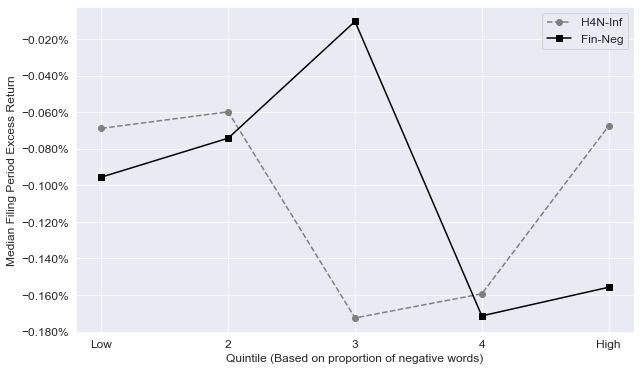

In [82]:
# plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(median1, linestyle='--', marker='o', color='grey', label = 'H4N-Inf')
plt.plot(median2, marker= 's', color='black', label = 'Fin-Neg')
plt.xlabel('Quintile (Based on proportion of negative words)', size = 12)
plt.ylabel('Median Filing Period Excess Return', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend(prop={'size': 12})
plt.savefig('result.png', dpi=500, bbox_inches='tight')

In the above plot, the median filing period excess returns by quintiles do not reflect a consistent relation with the proportion of negative words according to the H4N-Inf list, pretty much similar to that in Figure 1 in Loughran and MacDonald Analysis. Companies that have the highest proportions of Harvard negative words have very close 10-Q filing period returns with firms having the lowest proportions of Harvard negative words.\
The curve produced by the Fin-Neg list is a little bit better in capturing useful information. Though the return pattern for Fin-Neg across the quintiles is decreasing only from 3 to 4, firms that have the highest proportions of Fin-Neg negative words have much apparently lower filing period returns with firms having the lowest proportions of Fin-Neg negative words.\
From such difference, we can conclude that the Fin-Neg word list revealed more useful and rational information about those S&P500 Companies' 10-Q financial documents than the H4N-Inf list did.

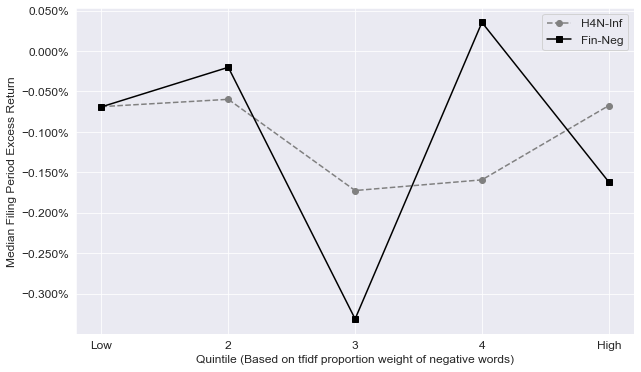

In [83]:
# plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize = (10,6))
plt.plot(median1, linestyle='--', marker='o', color='grey', label = 'H4N-Inf')
plt.plot(median3, marker= 's', color='black', label = 'Fin-Neg')
plt.xlabel('Quintile (Based on tfidf proportion weight of negative words)', size = 12)
plt.ylabel('Median Filing Period Excess Return', size = 12)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.legend(prop={'size': 12})
plt.savefig('result.png', dpi=500, bbox_inches='tight')

Using the tf.idf weighting scheme, the resulting curve for Fin-Neg list contained two decreasing patterns from quintiles 2nd to 3rd, and 4th to the highest separately. Also, firms that have the highest proportions (using the tf.idf weight) of Fin-Neg negative words have apparently lower filing period returns with firms having the lowest proportions of Fin-Neg negative words. However, the median filing period return at 4th quintile being the highest is a little bit irrational, maybe due to the fact that our parsing process didn't remove all non-sense information. Because in Loughran and MacDonald's Analysis, no graph was plotted based on this tf.idf weighting scheme, we couldn't conclude whether the Fin-Neg list is better in this case.

Unlike Figure 1 in Loughran and MacDonald Analysis, neither graph of us demonstrates an absolute negative correlation between the negative words proportion and excess return. We believe the following reasons might contribute to the difference:
1. Like most of the stocks in the market, the short-term fluctuation is always greater than long-term fluctuation. Including more documents each year certainly brings more information that might interfere the negative words proportion, and thus making the resulting correlation less stable than the only including yearly data.
2. The parsing process we applied isn't good enough to remove all unused information that might disturb the negative words proportion. Or we removed too much information that caused the significant part to be missed.
3. The look-forward return estimate might not be corresponding to the content of documents given their fixed filing dates.